# Problem Set 7

Iris Lan

In [1]:
import math, kplr, emcee, corner
from my_transit import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import quad
from scipy.stats import chi2
from scipy import interpolate
%matplotlib inline

In [2]:
# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
file = lcs[0].open()
hdu_data = file[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
ferr = hdu_data["sap_flux_err"] # get the error in the flux
file.close()

## Problem 1

extract the data in the time range 124 < t < 125

In [3]:
eidx = np.intersect1d(np.where(time <= 125.0), np.where(time >= 124.0))
time = time[eidx]
flux = flux[eidx]
ferr = ferr[eidx]

normalize flux and error with $\overline{F}^\prime,\overline{\sigma}^\prime $

In [4]:
def normalize(f, n):
    
    def two_sigma_clipping(flux):
        F_p, sigma_p = np.mean(flux), np.std(flux)
        idx = np.where(abs(flux - F_p) / sigma_p <= 2)
        return flux[idx]
    
    i = 0
    while i < n:
#         print(i)
        f = two_sigma_clipping(f)
        i += 1
    
    return np.mean(f), np.std(f)

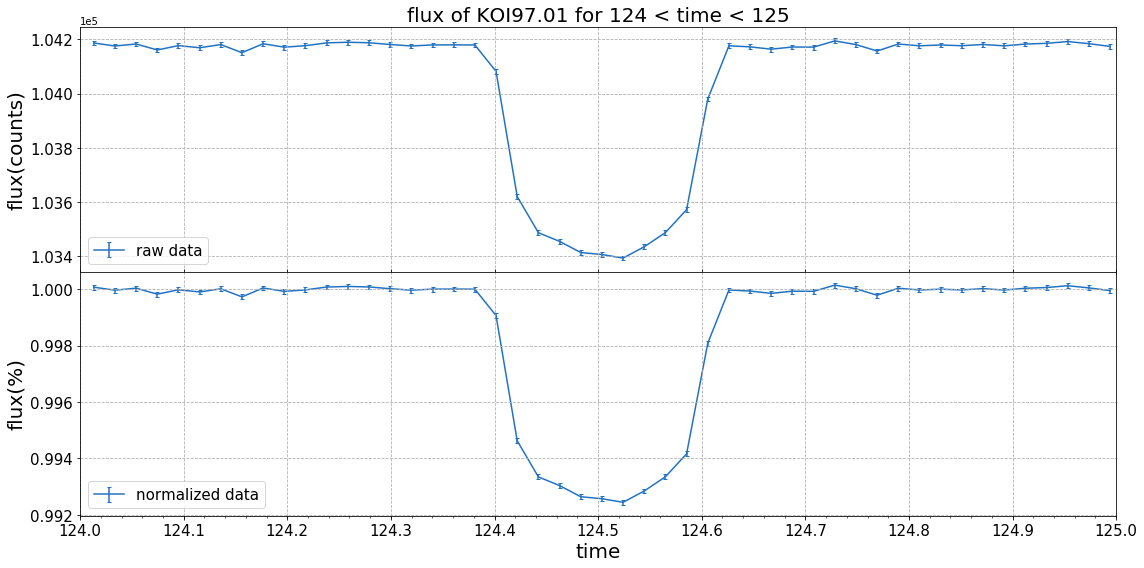

In [5]:
F_p, sigma_p = normalize(flux, 5)
nflux, nerr = flux / F_p, ferr / F_p

fig1, (axu, axb) = plt.subplots(2, 1, sharex = True, sharey = False, figsize = (16, 8))

axu.errorbar(time, flux, yerr = ferr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'raw data', zorder = 1)
axb.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)

for ax in (axu, axb):
    ax.grid(ls = '--')
    ax.legend(loc = 3, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)
    
axu.tick_params(axis = 'x', direction = 'in')
axu.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
axu.set_ylabel('flux(counts)', size = 20)
axu.set_title('flux of KOI97.01 for 124 < time < 125', fontsize = 20)

axb.set_xlim(124., 125.)
axb.set_xlabel('time', size = 20)
axb.xaxis.set_major_locator(MultipleLocator(.1))
axb.xaxis.set_minor_locator(MultipleLocator(.02))
axb.set_ylabel('flux(%)', size = 20)

fig1.tight_layout()
fig1.subplots_adjust(hspace = 0.)

define all the functions

In [6]:
def z_func(t, t_0, tau):
    '''convert time to z'''
    return (t - t_0) / tau
z = np.vectorize(z_func)

def func1(r, p, z):
    '''the numerator'''
    return I(r) * (1 - delta(p, r, abs(z))) * 2 * r

def func2(r, p, z):
    '''the denominator'''
    return I(r) * 2 * r

def I(r):
    '''A Limb-darkening functionm'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def Flux(p, z, **kwargs):
    return quad(func1, a = 0.0, b = 1.0, args = (p, z))[0] / quad(func2, a = 0.0, b = 1.0, args = (p, z))[0]
Flux = np.vectorize(Flux)

def chi_square(y, fit, sigma):
    return np.sum(((y - fit) / sigma)**2)

fit the light curve with $p = 0.0775, t_0 = 124.51, \tau = 0.1$ and compute the $\chi^2$

In [7]:
fit1 = Flux(p = 0.0775, z = z(time, t_0 = 124.51, tau = 0.1))
chi2_1 = chi_square(nflux, fit1, nerr)
print('chi2 = %.4f' % chi2_1)

chi2 = 465.1987


## Problem 2

plot the data and the predicted transit curve

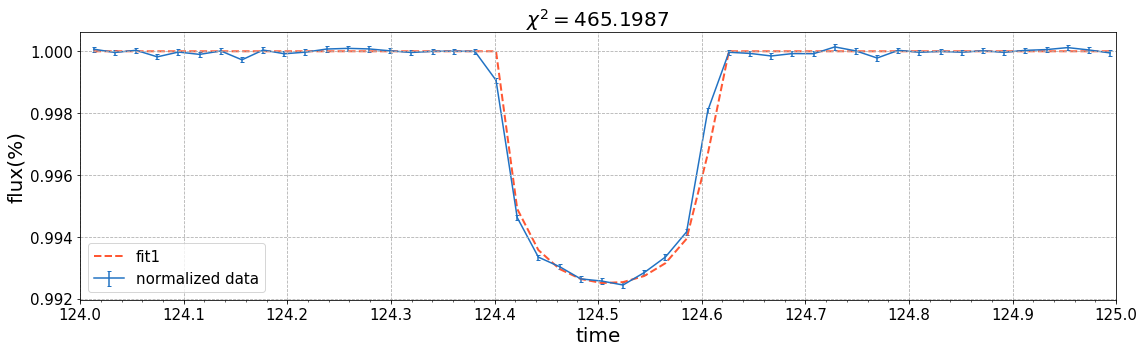

In [8]:
fig2, ax2 = plt.subplots(figsize = (16, 5))

ax2.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)
ax2.plot(time, fit1, 
             ls = '--', lw = 2, c = '#FF5733', label = 'fit1', zorder = 1)

ax2.set_xlim(124.0, 125.0)
ax2.tick_params(axis = 'both', labelsize = 15)
ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.02))
ax2.set_xlabel('time', size = 20)
ax2.set_ylabel('flux(%)', size = 20)
ax2.set_title('$\chi^2 = %.4f$' % chi2_1, fontsize = 20)
ax2.grid(ls = '--')
ax2.legend(loc = 3, fontsize = 15)

fig2.tight_layout()
fig2.subplots_adjust(hspace = 0.0)

The fit looks pretty good by eyes

In [9]:
# random variable object for len(nflux) - 3 degree of freedom
rv1 = chi2(len(nflux) - 3)
print('the p-value is %.5e << 10e-3' % rv1.sf(chi2_1) )

the p-value is 1.09887e-70 << 10e-3


The p-value suggests that our fit is not good enough

## Problem 3

vary $\tau$ between 0.08 and 0.13, compute $\chi^2$ with $p = 0.0775, t_0 = 124.51$

In [10]:
chi2_list = []
tau_list = np.linspace(0.08, 0.13, 1000)
for tau in tau_list:
    fit = Flux(p = 0.0775, z = z(time, t_0 = 124.51, tau = tau))
    chi2_list.append(chi_square(nflux, fit, nerr))

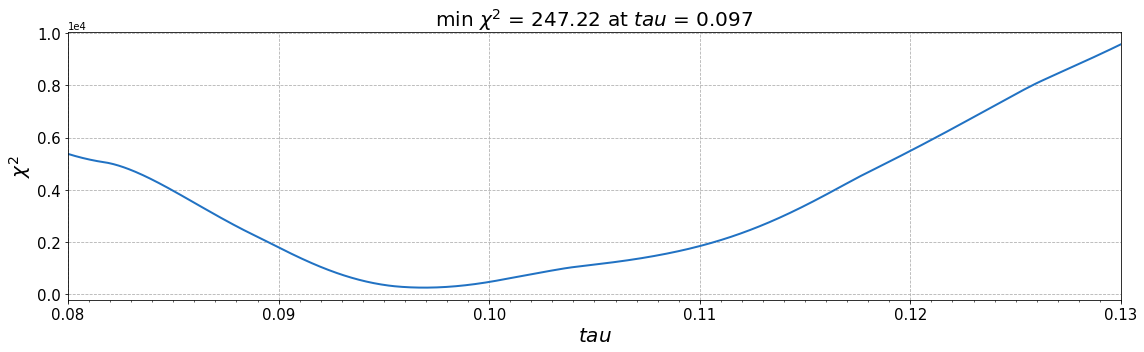

In [11]:
fig3, ax3 = plt.subplots(figsize = (16, 5))

ax3.plot(tau_list, chi2_list, ls = '-', lw = 2, c = '#2172C3', label = r'$\chi^2$', zorder = 2)
ax3.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
ax3.tick_params(axis = 'both', labelsize = 15)
ax3.set_xlim(0.08, 0.13)
ax3.set_xlabel('$\ttau$', size = 20)
ax3.set_ylabel('$\chi^2$', size = 20)
ax3.xaxis.set_major_locator(MultipleLocator(0.01))
ax3.xaxis.set_minor_locator(MultipleLocator(0.001))
ax3.set_title('min $\chi^2$ = %.2f at $\ttau$ = %.3f' % (np.min(chi2_list), tau_list[np.argmin(chi2_list)]), fontsize = 20)
ax3.grid(ls = '--')

fig3.tight_layout()

The best fitting $\tau$ value is 0.097

In [12]:
print('the corresponding p-value is %.3e' % rv1.sf(np.min(chi2_list)))

the corresponding p-value is 2.378e-29


In [13]:
yreduced = np.array(chi2_list) - (np.min(chi2_list) + 1)
freduced = interpolate.UnivariateSpline(tau_list, yreduced, s=0)
print('the one sigma uncertainty of tau is %.3e and %.3e' % tuple(freduced.roots() - tau_list[np.argmin(chi2_list)]))

the one sigma uncertainty of tau is -1.963e-04 and 2.009e-04


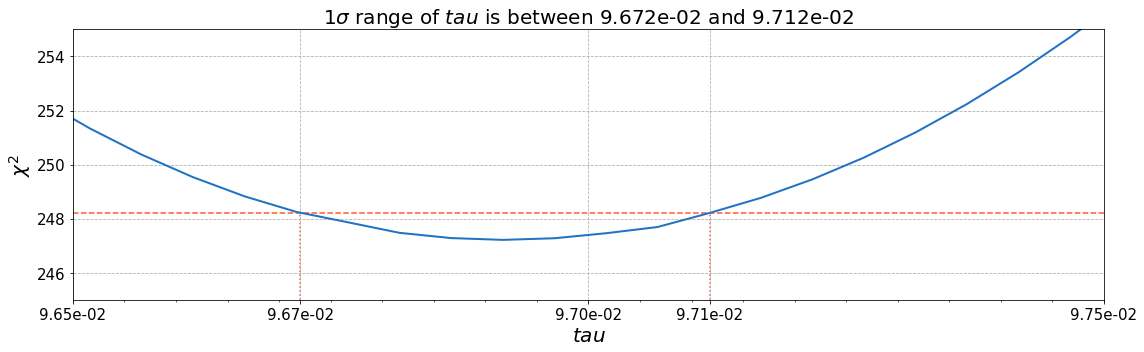

In [14]:
fig4, ax4 = plt.subplots(figsize = (16, 5))

ax4.plot(tau_list, chi2_list, ls = '-', lw = 2, c = '#2172C3', label = r'$\chi^2$', zorder = 2)
ax4.axhline(np.min(chi2_list) + 1, ls = '--', c = '#FF5733', label = r'$delta chi$', zorder = 1)
ax4.vlines(freduced.roots(), ymin = 240, ymax = np.min(chi2_list) + 1, 
           linestyles = 'dotted', color = '#FF5733', label = r'$delta chi$', zorder = 1)
ax4.tick_params(axis = 'both', labelsize = 15)

ax4.set_xlabel('$\ttau$', size = 20)
ax4.set_ylabel('$\chi^2$', size = 20)

ax4.xaxis.set_major_locator(MultipleLocator(5e-4))
ax4.set_xticks(list(ax4.get_xticks()) + list(freduced.roots()))
ax4.xaxis.set_minor_locator(MultipleLocator(5e-5))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))

ax4.set_xlim(9.65e-2, 9.75e-2)
ax4.set_ylim(245, 255)

ax4.set_title('1$\sigma$ range of $tau$ is between %.3e and %.3e' % tuple(freduced.roots()), fontsize = 20)
ax4.grid(ls = '--')
fig4.tight_layout()

compare with a quick MCMC to find the uncertainty of tau

In [15]:
delta_t = np.mean(np.diff(time))

def tau_model(tau, x, y, yerr):
    '''combining log_prior, log_like and log_prob into one function'''
    model = Flux(p = 0.0775, z = z_func(x, t_0 = 124.51, tau = tau))
    if delta_t < tau < .5:
        return -.5 * chi_square(y, model, yerr)
    else:
        return -np.inf

In [38]:
nwalkers_tau, nsteps_tau = 10, 500
tau_min = np.array([delta_t / 2])
tau_max = np.array([.5])
tau0 = [np.random.uniform(tau_min, tau_max) for i in np.arange(nwalkers_tau)]

sampler_tau = emcee.EnsembleSampler(nwalkers_tau, 1, tau_model, args = (time, nflux, nerr))
_, _, _ = sampler_tau.run_mcmc(tau0, nsteps_tau)

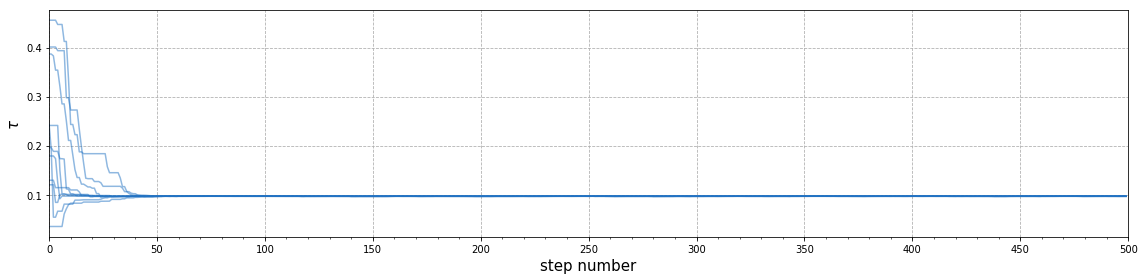

In [39]:
fig4b, ax4b = plt.subplots(figsize = (16, 4))

for n in np.arange(nwalkers_tau):
    ax4b.plot(np.arange(nsteps_tau), sampler_tau.chain[n, :], c = '#2172C3', alpha = 0.5)
ax4b.set_xlim(0, nsteps_tau)
ax4b.xaxis.set_major_locator(MultipleLocator(nsteps_tau / 10))
ax4b.xaxis.set_minor_locator(MultipleLocator(nsteps_tau / 50))
ax4b.set_ylabel(r'$\tau$', fontsize = 15)
ax4b.grid(ls = '--')
ax4b.set_xlabel('step number', fontsize = 15)
fig4b.tight_layout()
fig4b.subplots_adjust(hspace = 0.1)

burnin after about 100 steps

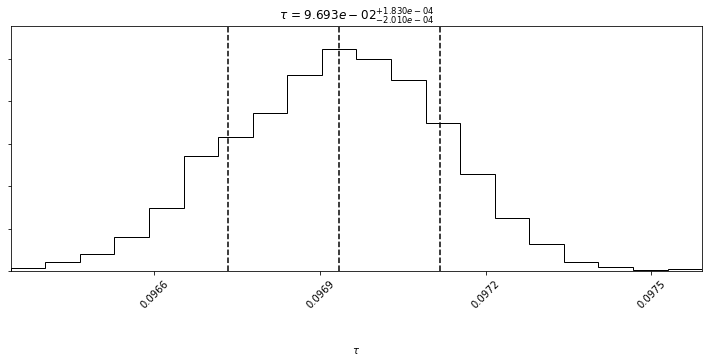

In [47]:
burnin_tau = 100
fig4c = corner.corner(np.reshape(sampler_tau.chain[:, burnin_tau:], (nwalkers_tau * (nsteps_tau - burnin_tau), 1)), 
                      quantiles = [0.16, 0.5, 0.84], show_titles = True, title_fmt='.3e', labels = [r'$\tau$'])
fig4c.set_size_inches(10, 5)
fig4c.tight_layout()

# Problem 4

setup MCMC model

In [25]:
def log_like(theta, x, y, yerr):
    p, tau, t_0 = theta
    model = Flux(p = p, z = z(x, t_0 = t_0, tau = tau))
    return -.5 * chi_square(y, model, yerr) - np.sum(np.log(yerr)) - .5 * len(y) * np.log(2 * np.pi)

def log_prior(theta):
    p, tau, t_0 = theta
    if 0. < p < 0.5 and delta_t / 2 < tau < 0.5 and 124.3 < t_0 < 124.7:
        return 0.0
    return -np.inf

def log_prob(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y, yerr)

run MCMC with 32 walkers

In [26]:
nwalkers, ndim, nsteps = 32, 3, 1000

# limits for p, tau, t_0
pos_min = np.array([0., delta_t / 2, 124.3])
pos_max = np.array([.5, .5, 124.7])
pos = [np.random.uniform(pos_min, pos_max) for i in np.arange(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args = (time, nflux, nerr))

Walk and plot

In [27]:
pos, prob, state = sampler.run_mcmc(pos, nsteps)

/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


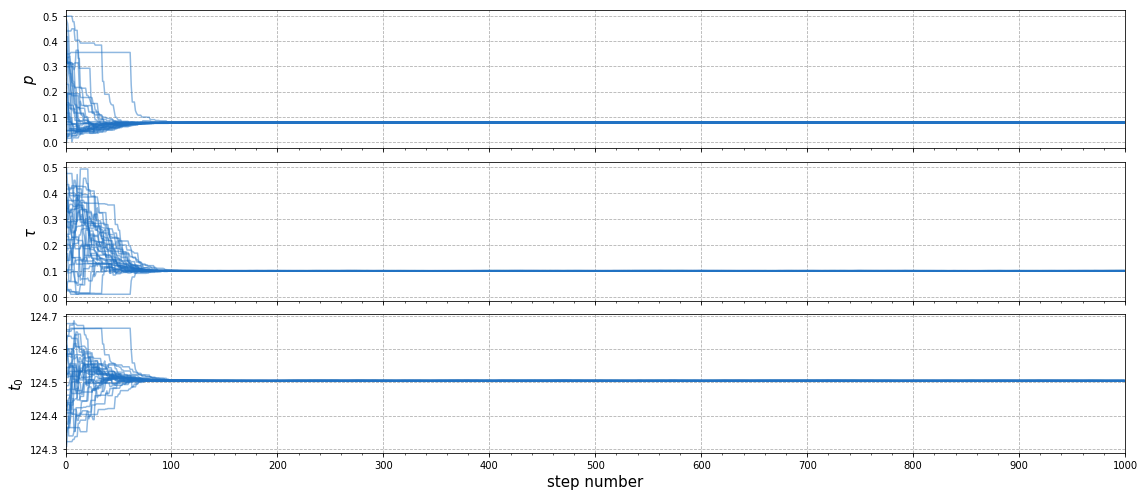

In [28]:
fig5, axes = plt.subplots(3, figsize = (16, 7), sharex = True)
samples = sampler.chain
labels = [r"$p$", r"$\tau$", r"$t_0$"]
for i in range(ndim):
    ax = axes[i]
    for n in np.arange(nwalkers):
        ax.plot(np.arange(nsteps), samples[n, :, i], c = '#2172C3', alpha = 0.5)
    ax.set_xlim(0, nsteps)
    ax.xaxis.set_major_locator(MultipleLocator(nsteps / 10))
    ax.xaxis.set_minor_locator(MultipleLocator(nsteps / 50))
    ax.set_ylabel(labels[i], fontsize = 15)
    ax.grid(ls = '--')

axes[-1].set_xlabel('step number', fontsize = 15)
fig5.tight_layout()
fig5.subplots_adjust(hspace = 0.1)

burn-in after ~200 steps. Verify with plots:

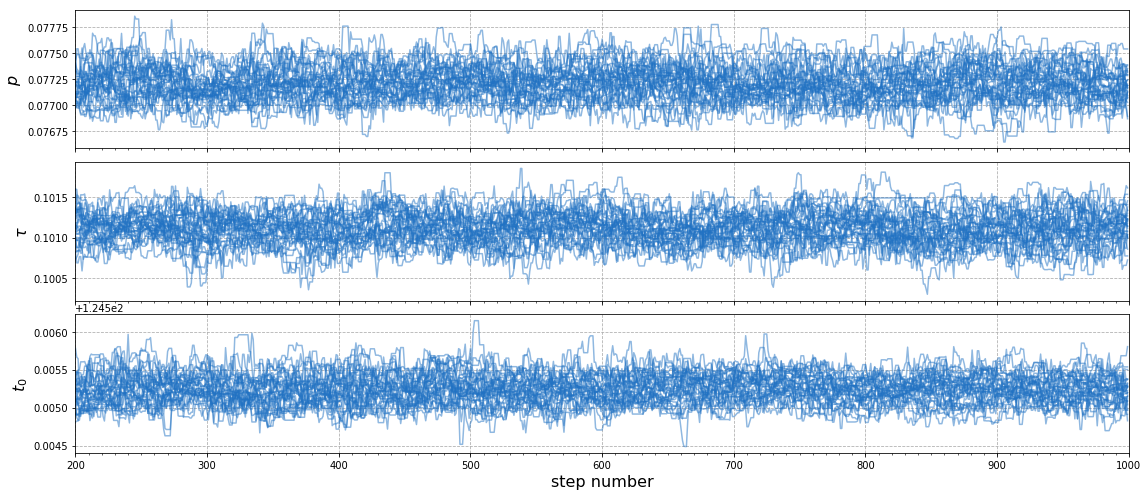

In [35]:
burnin = 200
fig6, axes = plt.subplots(3, figsize = (16, 7), sharex = True)
samples = sampler.chain
labels = ["$p$", r"$\tau$", r"$t_0$"]
for i in range(ndim):
    ax = axes[i]
    for n in np.arange(nwalkers):
        ax.plot(np.arange(burnin, nsteps), samples[n, burnin:, i], c = '#2172C3', alpha = 0.5)
    ax.set_xlim(burnin, nsteps)
    ax.xaxis.set_major_locator(MultipleLocator(nsteps / 10))
    ax.xaxis.set_minor_locator(MultipleLocator(nsteps / 100))
    ax.set_ylabel(labels[i], fontsize = 16)
    ax.grid(ls = '--')

axes[-1].set_xlabel('step number', fontsize = 16)
fig6.tight_layout()
fig6.subplots_adjust(hspace = 0.1)

looks good! Let's plot the fit with the best fit and the uncertainty shown on the corner plot

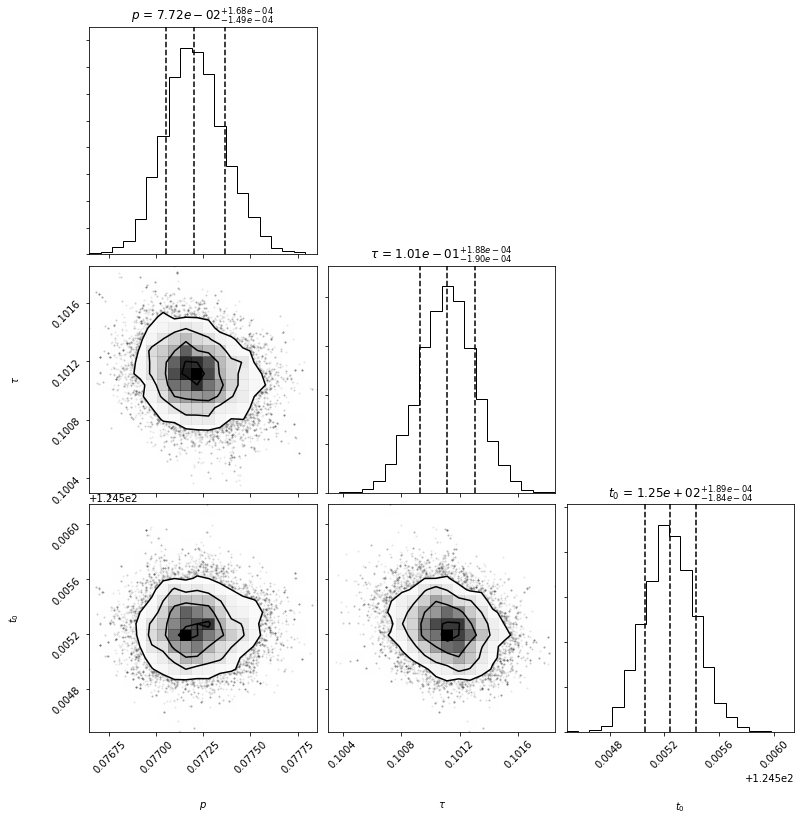

In [34]:
fig7 = corner.corner(np.reshape(samples[:, burnin:, :], (nwalkers * (nsteps - burnin), 3)), quantiles = [0.16, 0.5, 0.84], 
                     show_titles = True, title_fmt='.2e',
                     labels = labels, labels_args = {"fontsize": 20}, fontsize = 20)
fig7.set_size_inches(12,12)